## This file mitigates the problem of distribution shift shown in y_test_2_reduced.csv

## 1. Load Libraries and datasets

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from helper import weighted_log_loss
import xgboost as xgb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import sklearn.metrics as metrics

# Load resampled training data
X = pd.read_csv("Data/X_train.csv")
y = pd.read_csv("Data/y_train.csv")

# Load Test Set 2 and its reduced labels
X_test_2 = pd.read_csv("Data/X_test_2.csv")
y_test_2 = pd.read_csv("Data/y_test_2_reduced.csv")

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


## 2. Diagnose the problem

/var/folders/vx/tr_ckzyj0nzb1934vyp78y040000gn/T/ipykernel_28552/2178695760.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_labels["label"], palette='Blues', order=sorted(train_labels["label"].unique()))


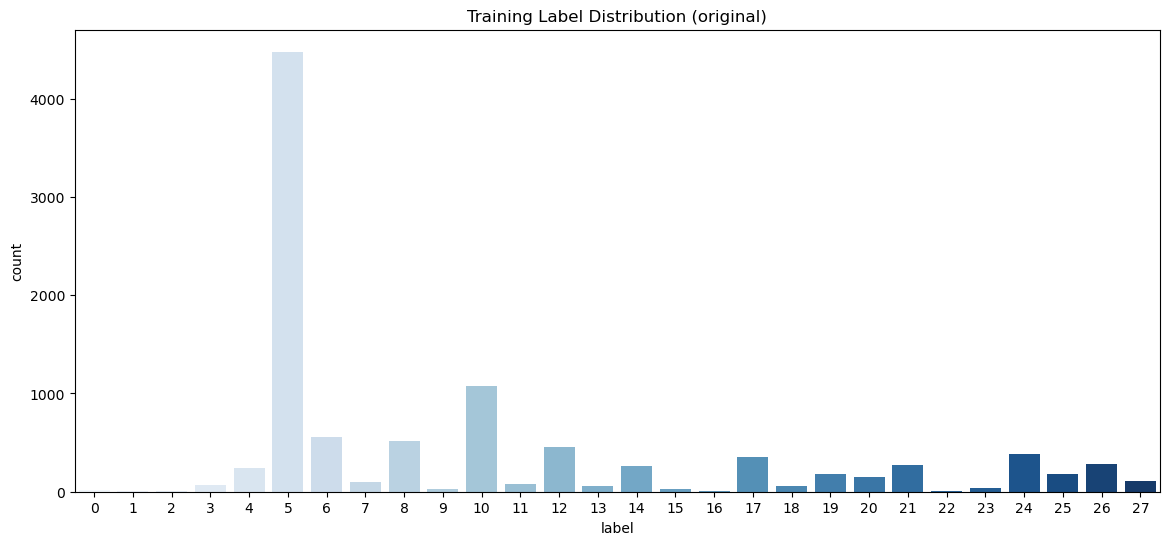

/var/folders/vx/tr_ckzyj0nzb1934vyp78y040000gn/T/ipykernel_28552/2178695760.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=test_labels["label"], palette='Reds', order=sorted(test_labels["label"].unique()))


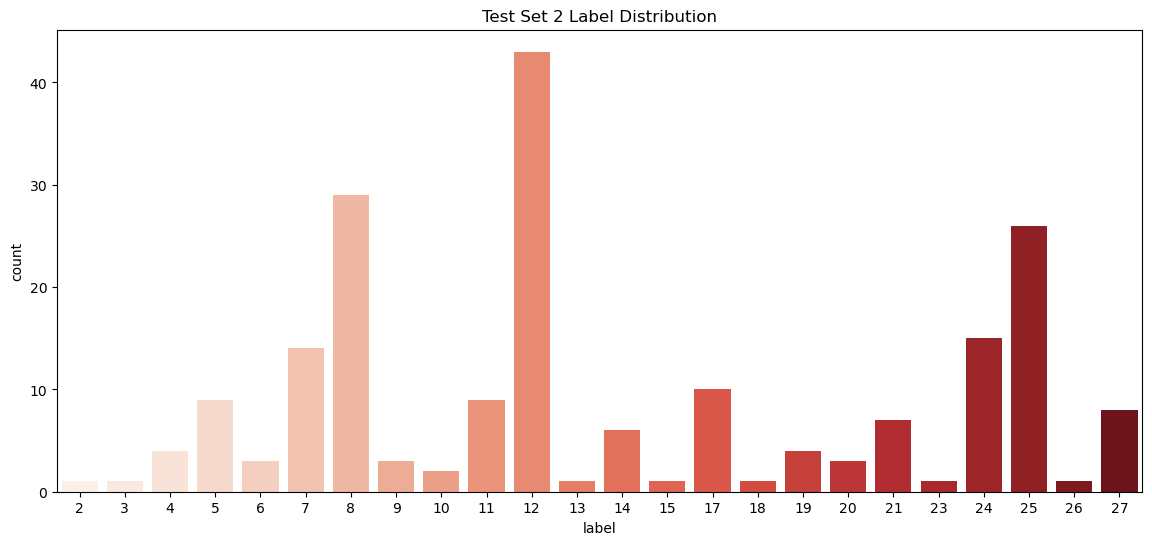

KL Divergence between test2 and train label distributions: 0.9445


In [2]:
def plot_label_distribution(train_labels, test_labels):
    plt.figure(figsize=(14, 6))
    sns.countplot(x=train_labels["label"], palette='Blues', order=sorted(train_labels["label"].unique()))
    plt.title("Training Label Distribution (original)")
    plt.show()

    plt.figure(figsize=(14, 6))
    sns.countplot(x=test_labels["label"], palette='Reds', order=sorted(test_labels["label"].unique()))
    plt.title("Test Set 2 Label Distribution")
    plt.show()

plot_label_distribution(y, y_test_2)

# KL divergence between label distributions
def compute_kl_divergence(train_labels, test_labels):
    train_dist = train_labels['label'].value_counts(normalize=True).sort_index()
    test_dist = test_labels['label'].value_counts(normalize=True).sort_index()
    all_classes = sorted(set(train_dist.index).union(set(test_dist.index)))
    train_probs = [train_dist.get(c, 1e-10) for c in all_classes]
    test_probs = [test_dist.get(c, 1e-10) for c in all_classes]
    kl_div = entropy(test_probs, train_probs)
    print(f"KL Divergence between test2 and train label distributions: {kl_div:.4f}")

compute_kl_divergence(y, y_test_2)

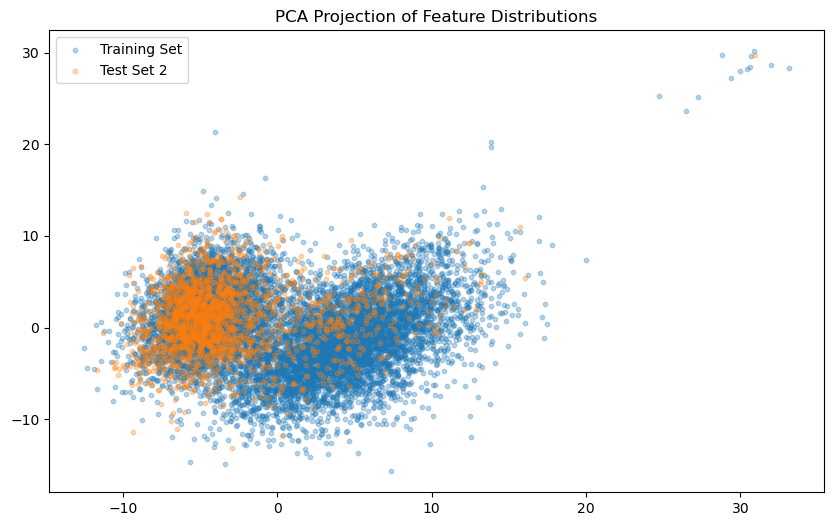

In [3]:
# PCA to visualize feature distribution
def plot_pca_feature_shift(X1, X2, label):
    pca = PCA(n_components=2)
    all_data = pd.concat([X1, X2])
    reduced = pca.fit_transform(all_data)

    X1_reduced = reduced[:len(X1)]
    X2_reduced = reduced[len(X1):]

    plt.figure(figsize=(10, 6))
    plt.scatter(X1_reduced[:, 0], X1_reduced[:, 1], alpha=0.3, label='Training Set', s=10)
    plt.scatter(X2_reduced[:, 0], X2_reduced[:, 1], alpha=0.3, label='Test Set 2', s=10)
    plt.title('PCA Projection of Feature Distributions')
    plt.legend()
    plt.show()

plot_pca_feature_shift(X, X_test_2, label='Feature Shift')

In [8]:
# Load datasets
X_train = pd.read_csv("Data/X_train.csv")
X_test2 = pd.read_csv("Data/X_test_2.csv")

# Add domain labels: 0 for train, 1 for test2
X_train['domain'] = 0
X_test2['domain'] = 1

# Combine for domain classification
domain_data = pd.concat([X_train, X_test2])
X = domain_data.drop(columns=["domain"])
y = domain_data["domain"]

# Split for evaluation
X_tr, X_val, y_tr, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train a logistic regression classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_tr, y_tr)

# Predict and evaluate AUC
probs = clf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, probs)

auc

0.7451126237623762

# 3. Handling Distribution Shift

## 3.1 Random Forest on Resampled Training Set

In [26]:
# Load data
X_train = pd.read_csv('Data/resampled_X_train.csv')  
y_train = pd.read_csv('Data/resampled_y_train.csv')['label']

X_test2 = pd.read_csv('Data/X_test_2.csv')  
X_test2_labeled = X_test2.iloc[:202]
y_test2 = pd.read_csv('Data/y_test_2_reduced.csv')['label']

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test2_enc = le.transform(y_test2)
n_classes = len(le.classes_)

# Train model
clf = RandomForestClassifier(class_weight=None, random_state=42)
clf.fit(X_train, y_train_enc)

# Predict probabilities
y_pred_proba = clf.predict_proba(X_test2_labeled)

# One-hot encode y_test2 safely
y_true_ohe = np.zeros((len(y_test2_enc), n_classes))
y_true_ohe[np.arange(len(y_test2_enc)), y_test2_enc] = 1

# 🛡️ Slice only the columns that exist in y_true to avoid NaN in helper
active_classes = np.where(y_true_ohe.sum(axis=0) > 0)[0]
y_true_filtered = y_true_ohe[:, active_classes]
y_pred_filtered = y_pred_proba[:, active_classes]
eps = 1e-12
y_pred_filtered = np.clip(y_pred_filtered, eps, 1.0)

loss = weighted_log_loss(y_true_filtered, y_pred_filtered)
print("✅ Weighted Cross-Entropy Loss on labeled test2:", round(loss, 5))

# Print classification report on present labels only
present_labels = np.array(sorted(np.unique(y_test2_enc)))
present_label_names = [str(label) for label in le.inverse_transform(present_labels)]

print(classification_report(
    y_test2_enc,
    np.argmax(y_pred_proba, axis=1),
    labels=present_labels,
    target_names=present_label_names,
    digits=3
))

✅ Weighted Cross-Entropy Loss on labeled test2: 0.02537
              precision    recall  f1-score   support

           2      0.000     0.000     0.000         1
           3      0.000     0.000     0.000         1
           4      0.267     1.000     0.421         4
           5      0.667     0.444     0.533         9
           6      0.500     1.000     0.667         3
           7      0.889     0.571     0.696        14
           8      0.727     0.828     0.774        29
           9      0.000     0.000     0.000         3
          10      0.250     1.000     0.400         2
          11      0.692     1.000     0.818         9
          12      0.850     0.395     0.540        43
          13      0.333     1.000     0.500         1
          14      0.333     0.500     0.400         6
          15      0.000     0.000     0.000         1
          17      0.700     0.700     0.700        10
          18      0.000     0.000     0.000         1
          19      0.200  

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 3.2 XGBoost

In [ ]:
# Load resampled training and test2 data
X_train_resampled = pd.read_csv("Data/resampled_X_train.csv")
y_train_resampled = pd.read_csv("Data/resampled_y_train.csv")
X_test2 = pd.read_csv("Data/X_test_2.csv")
y_test2 = pd.read_csv("Data/y_test_2_reduced.csv")

# Add domain labels and concatenate
X_train_with_domain = X_train_resampled.copy()
X_train_with_domain['domain'] = 0
X_test2_with_domain = X_test2.copy()
X_test2_with_domain['domain'] = 1

X_domain = pd.concat([X_train_with_domain, X_test2_with_domain])
y_domain = X_domain['domain']
X_domain = X_domain.drop(columns=['domain'])

# Train domain classifier and compute importance weights
domain_clf = LogisticRegression(max_iter=1000)
domain_clf.fit(X_domain, y_domain)
train_domain_probs = domain_clf.predict_proba(X_train_resampled)[:, 1]
importance_weights = train_domain_probs / (1 - train_domain_probs + 1e-6)

# Label encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y_train_resampled["label"])
y_test2_encoded = le.transform(y_test2["label"])

# Drop domain before model training
X_train_for_xgb = X_train_resampled.copy()

xgb_clf = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=28,
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_clf.fit(X_train_for_xgb, y_encoded, sample_weight=importance_weights)

# Predict probabilities
X_test2_labeled = X_test2.loc[y_test2.index]
y_pred_probs = xgb_clf.predict_proba(X_test2_labeled)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# One-hot encode y_test2
y_test2_onehot = np.zeros((len(y_test2_encoded), 28))
y_test2_onehot[np.arange(len(y_test2_encoded)), y_test2_encoded] = 1

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:18:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Observing that class 0, 1, 16 and 22 were missing in the test2 set

In [3]:
unique, counts = np.unique(y_test2_encoded, return_counts=True)
class_distribution = dict(zip(unique, counts))

print("Classes present in y_test2:")
print(sorted(class_distribution.keys()))
print(f"Number of present classes: {len(class_distribution)} / 28")

missing_classes = set(range(28)) - set(class_distribution.keys())
print("⚠️ Missing classes:", sorted(missing_classes))

Classes present in y_test2:
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27]
Number of present classes: 24 / 28
⚠️ Missing classes: [0, 1, 16, 22]


In [16]:
missing_classes = [0, 1, 16, 22]

for cls in missing_classes:
    y_test2_onehot[:, cls] = 0
    y_pred_probs[:, cls] = 1e-12  # small non-zero to avoid log(0)

active_classes = np.where(y_test2_onehot.sum(axis=0) > 0)[0]
y_true_filtered = y_test2_onehot[:, active_classes]
y_pred_filtered = y_pred_probs[:, active_classes]

# Use helper cross-entropy function
wce_loss = weighted_log_loss(y_true_filtered, y_pred_filtered)

# Accuracy and F1
acc = accuracy_score(y_test2_encoded, y_pred_labels)
f1_macro = f1_score(y_test2_encoded, y_pred_labels, average='macro')

# Classification report (only on present labels)
present_labels = sorted(np.unique(y_test2_encoded))
present_label_names = [str(label) for label in le.inverse_transform(present_labels)]

print(f"✅ Weighted Cross-Entropy Loss: {wce_loss:.5f}")
print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ Macro F1-score: {f1_macro:.4f}\n")

print("📊 Classification Report:")
print(classification_report(
    y_test2_encoded,
    y_pred_labels,
    labels=present_labels,
    target_names=present_label_names,
    digits=3
))

✅ Weighted Cross-Entropy Loss: 0.02036
✅ Accuracy: 0.6188
✅ Macro F1-score: 0.4428

📊 Classification Report:
              precision    recall  f1-score   support

           2      0.000     0.000     0.000         1
           3      0.000     0.000     0.000         1
           4      0.222     0.500     0.308         4
           5      0.333     0.111     0.167         9
           6      0.400     0.667     0.500         3
           7      0.778     0.500     0.609        14
           8      0.870     0.690     0.769        29
           9      0.000     0.000     0.000         3
          10      0.250     1.000     0.400         2
          11      1.000     1.000     1.000         9
          12      0.778     0.651     0.709        43
          13      0.000     0.000     0.000         1
          14      0.400     0.667     0.500         6
          15      1.000     1.000     1.000         1
          17      0.667     0.800     0.727        10
          18      0.000   

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 3.3 Domain-Adversarial Neural Networks(DANN)

In [ ]:
# Load data
X_train = pd.read_csv("Data/resampled_X_train.csv").values.astype(np.float32)
y_train = pd.read_csv("Data/resampled_y_train.csv")["label"]
X_test2 = pd.read_csv("Data/X_test_2.csv").values.astype(np.float32)
y_test2 = pd.read_csv("Data/y_test_2_reduced.csv")["label"]

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test2_enc = le.transform(y_test2)
n_classes = len(le.classes_)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train_enc)
X_test_tensor = torch.tensor(X_test2[y_test2.index])
y_test_tensor = torch.tensor(y_test2_enc)

# Build dataset with domain labels
train_domain_labels = torch.zeros(len(X_train_tensor)).long()
test_domain_labels = torch.ones(len(X_test_tensor)).long()

X_all = torch.cat([X_train_tensor, X_test_tensor], dim=0)
y_all = torch.cat([y_train_tensor, y_test_tensor], dim=0)
d_all = torch.cat([train_domain_labels, test_domain_labels], dim=0)

class CombinedDataset(Dataset):
    def __init__(self, X, y, d):
        self.X = X
        self.y = y
        self.d = d

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.d[idx]

combined_dataset = CombinedDataset(X_all, y_all, d_all)
train_size = int(0.9 * len(combined_dataset))
val_size = len(combined_dataset) - train_size
train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)

# Define the Gradient Reversal Layer
class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

# Define the DANN model
class DANN(nn.Module):
    def __init__(self, input_dim, class_num, domain_num=2):
        super(DANN, self).__init__()
        self.feature = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.class_classifier = nn.Sequential(
            nn.Linear(64, class_num)
        )
        self.domain_classifier = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, domain_num)
        )

    def forward(self, x, alpha=0.0):
        feat = self.feature(x)
        reverse_feat = GradReverse.apply(feat, alpha)
        class_out = self.class_classifier(feat)
        domain_out = self.domain_classifier(reverse_feat)
        return class_out, domain_out

# Instantiate model
model = DANN(input_dim=300, class_num=n_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion_class = nn.CrossEntropyLoss()
criterion_domain = nn.CrossEntropyLoss()

# Train loop (short version for demonstration)
def train_dann(model, loader, optimizer, n_epochs=10, lambda_val=0.1):
    model.train()
    for epoch in range(n_epochs):
        for X_batch, y_batch, d_batch in loader:
            X_batch, y_batch, d_batch = X_batch.to(device), y_batch.to(device), d_batch.to(device)
            optimizer.zero_grad()
            class_logits, domain_logits = model(X_batch, alpha=lambda_val)
            loss_class = criterion_class(class_logits, y_batch)
            loss_domain = criterion_domain(domain_logits, d_batch)
            loss = loss_class + loss_domain
            loss.backward()
            optimizer.step()

train_dann(model, train_loader, optimizer)

# Evaluate on labeled test2
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    class_logits, _ = model(X_test_tensor)
    y_pred = torch.argmax(class_logits, dim=1).cpu().numpy()

# Prepare classification report
report = metrics.classification_report(y_test2_enc, y_pred, digits=3, zero_division=0, output_dict=False)
print(report)

# Load data
X_train = pd.read_csv("Data/resampled_X_train.csv").values.astype(np.float32)
y_train = pd.read_csv("Data/resampled_y_train.csv")["label"]
X_test2 = pd.read_csv("Data/X_test_2.csv").values.astype(np.float32)
y_test2 = pd.read_csv("Data/y_test_2_reduced.csv")["label"]

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test2_enc = le.transform(y_test2)
n_classes = len(le.classes_)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train_enc)
X_test_tensor = torch.tensor(X_test2[y_test2.index])
y_test_tensor = torch.tensor(y_test2_enc)

# Build dataset with domain labels
train_domain_labels = torch.zeros(len(X_train_tensor)).long()
test_domain_labels = torch.ones(len(X_test_tensor)).long()

X_all = torch.cat([X_train_tensor, X_test_tensor], dim=0)
y_all = torch.cat([y_train_tensor, y_test_tensor], dim=0)
d_all = torch.cat([train_domain_labels, test_domain_labels], dim=0)

class CombinedDataset(Dataset):
    def __init__(self, X, y, d):
        self.X = X
        self.y = y
        self.d = d

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.d[idx]

combined_dataset = CombinedDataset(X_all, y_all, d_all)
train_size = int(0.9 * len(combined_dataset))
val_size = len(combined_dataset) - train_size
train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)

# Define the Gradient Reversal Layer
class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

# Define the DANN model
class DANN(nn.Module):
    def __init__(self, input_dim, class_num, domain_num=2):
        super(DANN, self).__init__()
        self.feature = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3), #Drop out layer to mitigate the problem of overfitting
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.class_classifier = nn.Sequential(
            nn.Linear(64, class_num)
        )
        self.domain_classifier = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, domain_num)
        )

    def forward(self, x, alpha=0.0):
        feat = self.feature(x)
        reverse_feat = GradReverse.apply(feat, alpha)
        class_out = self.class_classifier(feat)
        domain_out = self.domain_classifier(reverse_feat)
        return class_out, domain_out

# Instantiate model
model = DANN(input_dim=300, class_num=n_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion_class = nn.CrossEntropyLoss()
criterion_domain = nn.CrossEntropyLoss()

# Train loop (short version for demonstration)
def train_dann(model, loader, optimizer, n_epochs=10, lambda_val=0.1):
    model.train()
    for epoch in range(n_epochs):
        for X_batch, y_batch, d_batch in loader:
            X_batch, y_batch, d_batch = X_batch.to(device), y_batch.to(device), d_batch.to(device)
            optimizer.zero_grad()
            class_logits, domain_logits = model(X_batch, alpha=lambda_val)
            loss_class = criterion_class(class_logits, y_batch)
            loss_domain = criterion_domain(domain_logits, d_batch)
            loss = loss_class + loss_domain
            loss.backward()
            optimizer.step()

train_dann(model, train_loader, optimizer)

              precision    recall  f1-score   support

           0      0.000     0.000     0.000         0
           2      0.000     0.000     0.000         1
           3      1.000     1.000     1.000         1
           4      0.444     1.000     0.615         4
           5      0.667     0.444     0.533         9
           6      0.600     1.000     0.750         3
           7      0.833     0.714     0.769        14
           8      0.923     0.828     0.873        29
           9      1.000     0.333     0.500         3
          10      0.400     1.000     0.571         2
          11      1.000     1.000     1.000         9
          12      0.882     0.698     0.779        43
          13      0.500     1.000     0.667         1
          14      0.444     0.667     0.533         6
          15      1.000     1.000     1.000         1
          17      0.900     0.900     0.900        10
          18      0.000     0.000     0.000         1
          19      0.667    

### Evaluate the model

In [25]:
# Evaluate on labeled test2
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    class_logits, _ = model(X_test_tensor)
    y_pred = torch.argmax(class_logits, dim=1).cpu().numpy()

# Prepare softmax probabilities from logits
y_pred_probs = F.softmax(class_logits, dim=1).cpu().numpy()

# Recreate one-hot true labels
y_test2_onehot = np.zeros_like(y_pred_probs)
y_test2_onehot[np.arange(len(y_test2_enc)), y_test2_enc] = 1

# Filter to active classes
active_classes = np.where(y_test2_onehot.sum(axis=0) > 0)[0]
y_true_filtered = y_test2_onehot[:, active_classes]
y_pred_filtered = y_pred_probs[:, active_classes]
y_pred_filtered = np.clip(y_pred_filtered, 1e-12, 1.0)

# Calculate weighted cross-entropy loss as main metric
wce_loss = weighted_log_loss(y_true_filtered, y_pred_filtered)
print(wce_loss)

# Also calculate accuracy and F1
y_pred_labels = np.argmax(y_pred_probs, axis=1)
acc = accuracy_score(y_test2_enc, y_pred_labels)
f1_macro = f1_score(y_test2_enc, y_pred_labels, average='macro')
report = classification_report(y_test2_enc, y_pred_labels, digits=3, zero_division=0)
print(report)

0.006096561
              precision    recall  f1-score   support

           2      1.000     1.000     1.000         1
           3      0.500     1.000     0.667         1
           4      0.400     1.000     0.571         4
           5      1.000     0.444     0.615         9
           6      0.750     1.000     0.857         3
           7      1.000     0.786     0.880        14
           8      0.926     0.862     0.893        29
           9      1.000     0.667     0.800         3
          10      1.000     1.000     1.000         2
          11      0.818     1.000     0.900         9
          12      0.838     0.721     0.775        43
          13      0.500     1.000     0.667         1
          14      0.500     1.000     0.667         6
          15      1.000     1.000     1.000         1
          17      0.818     0.900     0.857        10
          18      0.000     0.000     0.000         1
          19      1.000     1.000     1.000         4
          20   

### Make predictions on DANN

In [32]:
# Load the full X_test_2 dataset for prediction
X_test2 = pd.read_csv("Data/X_test_2.csv").values.astype(np.float32)
X_test2_unlabeled = X_test2[202:]
X_test2_tensor = torch.tensor(X_test2_unlabeled).to(device)

model.eval()
with torch.no_grad():
    logits, _ = model(X_test2_tensor)
    probs = F.softmax(logits, dim=1).cpu().numpy()

# Confirm correct shape
assert probs.shape == (1818, 28), f"Expected (1818, 28), got {probs.shape}"

# Save to file
np.save("preds_2.npy", probs)